In [1]:
# Import packages
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
#import sys
import math
import datetime as dt
import yfinance as yf
#import functools as reduce

In [2]:
# Function to extract stock data we want
def get_stock_data(tickers, num_days_back, info_type):
    """Takes in a list of stock tickers, the number of days into
    the past we want data from and the type of price information, and 
    returns a Pandas dataframe with the stock data"""
    
    end_date = dt.datetime.now()
    start_date = end_date - dt.timedelta(days = num_days_back)
    
    # Initialize a dataframe to store stock data
    df = pd.DataFrame()
    
    # For each stock, download the desired information
    for ticker in tickers:
        data = yf.download(ticker, start = start_date, end = end_date)
        df[ticker] = data[info_type]
    
    return df

In [3]:
# Sustainable Stocks/Tickers we want to analyze
stocks_sustainable = ["AQN", "BEPC", "CEG", "CSIQ", "DQ", "GE", "IBDRY", "JKS", "NEE", "VWDRY"]

# Unsustainable companies tickers
stocks_unsustainable = ["EQNR", "BP", "0857.HK", "COP", "FP.VI", "SHEL", "CVX", "SR", "ENEL.MI"]

df_sustain = get_stock_data(tickers = stocks_sustainable, num_days_back = 1000, info_type = "Adj Close")
df_unsustain = get_stock_data(tickers = stocks_unsustainable, num_days_back = 1000, info_type = "Adj Close")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Models

In [4]:
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [13]:
# Take just EQNR as an experiment
df1 = df_unsustain["EQNR"]

In [15]:
returns = 100 * df1.pct_change().dropna()

print(returns)

Date
2021-04-06    1.489485
2021-04-07    0.202407
2021-04-08   -2.727254
2021-04-09   -1.713405
2021-04-12    0.211293
                ...   
2023-12-22    0.506329
2023-12-26    1.574301
2023-12-27   -0.092991
2023-12-28   -2.078809
2023-12-29    0.253485
Name: EQNR, Length: 690, dtype: float64


Text(0.5, 1.0, 'EQNR Returns')

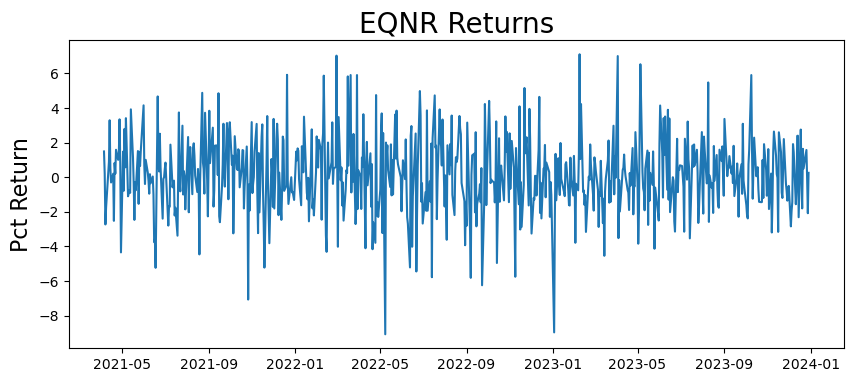

In [16]:
plt.figure(figsize = (10, 4))
plt.plot(returns)
plt.ylabel("Pct Return", fontsize = 16)
plt.title("EQNR Returns", fontsize = 20)

### PACF

C:\Users\jirka\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


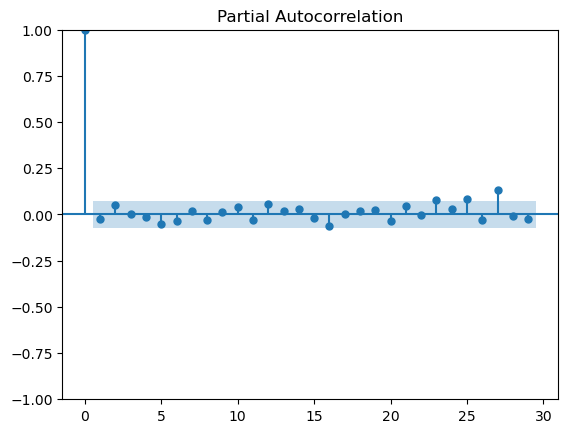

In [19]:
plot_pacf(returns**2)
plt.show() # Not very autocorrelated returns variance

In [24]:
model_1 = arch_model(returns, p = 2, q = 2)

In [21]:
model_fit = model_1.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1768.743860978299
Iteration:      2,   Func. Count:     20,   Neg. LLF: 524625.8861683303
Iteration:      3,   Func. Count:     30,   Neg. LLF: 1523.9412040951233
Iteration:      4,   Func. Count:     38,   Neg. LLF: 1521.2114432168278
Iteration:      5,   Func. Count:     46,   Neg. LLF: 1518.097868805616
Iteration:      6,   Func. Count:     54,   Neg. LLF: 1517.7639195947593
Iteration:      7,   Func. Count:     62,   Neg. LLF: 1518.0717065175766
Iteration:      8,   Func. Count:     70,   Neg. LLF: 1517.8929145221255
Iteration:      9,   Func. Count:     78,   Neg. LLF: 1517.9109178618792
Iteration:     10,   Func. Count:     86,   Neg. LLF: 1517.846775562081
Iteration:     11,   Func. Count:     94,   Neg. LLF: 1516.025602316631
Iteration:     12,   Func. Count:    102,   Neg. LLF: 1517.9371917485441
Iteration:     13,   Func. Count:    110,   Neg. LLF: 1514.9886778605462
Iteration:     14,   Func. Count:    117,   Neg. LLF: 15

In [55]:
# Insignificant -> not a useful choice
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQN   No. Observations:                  607
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 185.919
Date:                Tue, 02 Jan 2024   AIC                           -363.838
Time:                        10:43:00   BIC                           -346.204
Sample:                             0   HQIC                          -356.977
                                - 607                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0108      0.010     -1.124      0.261      -0.030       0.008
ar.L1          0.1959      0.482      0.406      0.684      -0.749       1.141
ma.L1         -0.1035      0.472     -0.219      0.8

### ARIMA model

Text(0.5, 1.0, 'EQNR Returns')

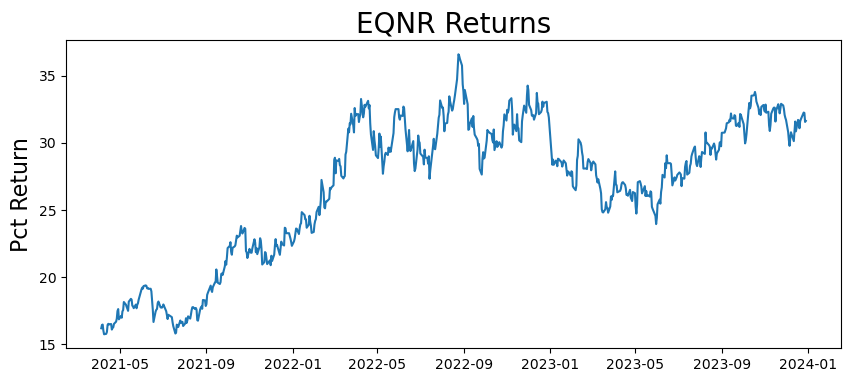

In [26]:
# Series does not look stationary
plt.figure(figsize = (10, 4))
plt.plot(df1)
plt.ylabel("Price", fontsize = 16)
plt.title("EQNR price", fontsize = 20)

Text(0.5, 1.0, 'EQNR first differenced')

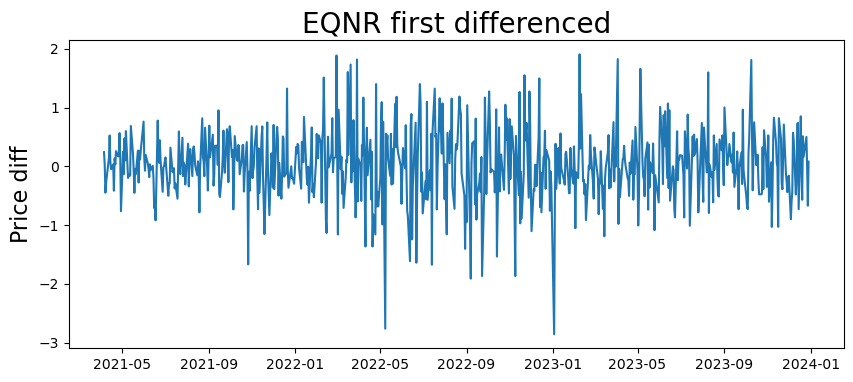

In [28]:
# First differencing
df1_diff = df1.diff().dropna()

# seems more stationary now
plt.figure(figsize = (10, 4))
plt.plot(df1_diff)
plt.ylabel("Price diff", fontsize = 16)
plt.title("EQNR first differenced", fontsize = 20)

C:\Users\jirka\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


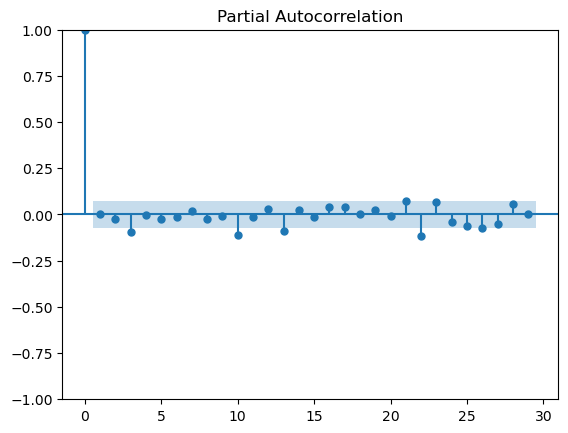

In [29]:
# PACF -> a little more autocorrelation here
plot_pacf(df1_diff)
plt.show()

# ARMA

## 1. AQN

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [6]:
# Choose a stock from the dataset
df2 = df_sustain["AQN"]
df2.head(3)

Date
2021-04-06    13.942659
2021-04-07    13.857643
2021-04-08    13.951162
Name: AQN, dtype: float64

Text(0.5, 1.0, 'AQN price')

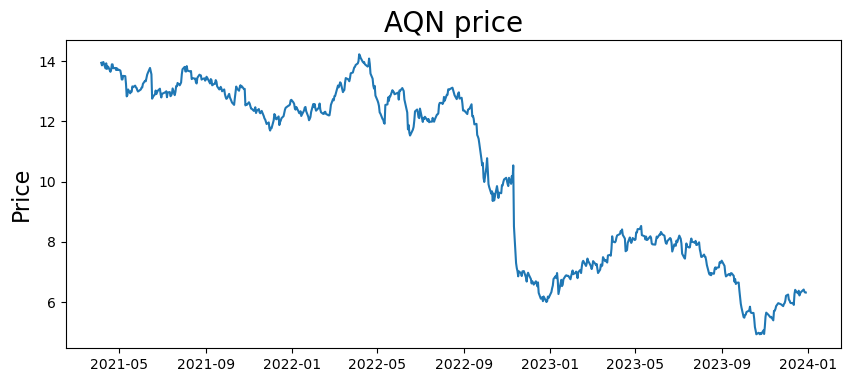

In [7]:
# Plot the prices -> non-stationary
plt.figure(figsize = (10, 4))
plt.plot(df2)
plt.ylabel("Price", fontsize = 16)
plt.title("AQN price", fontsize = 20)

Text(0.5, 1.0, 'AQN first differenced')

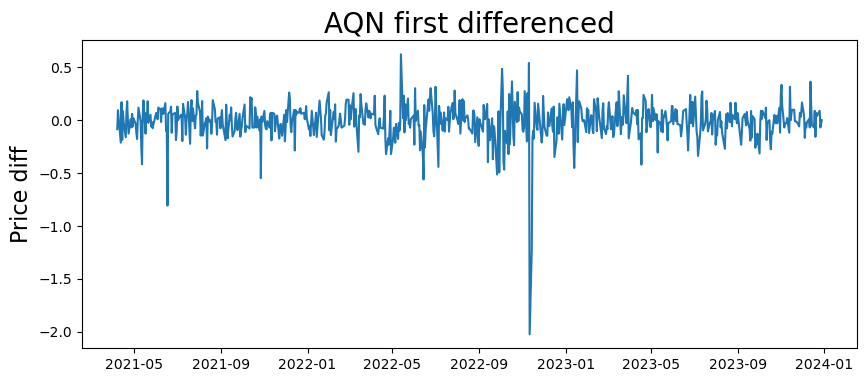

In [8]:
# First-Differences
df2_diff = df2.diff().dropna()

# seems more stationary now
plt.figure(figsize = (10, 4))
plt.plot(df2_diff)
plt.ylabel("Price diff", fontsize = 16)
plt.title("AQN first differenced", fontsize = 20)

<function matplotlib.pyplot.show(close=None, block=None)>

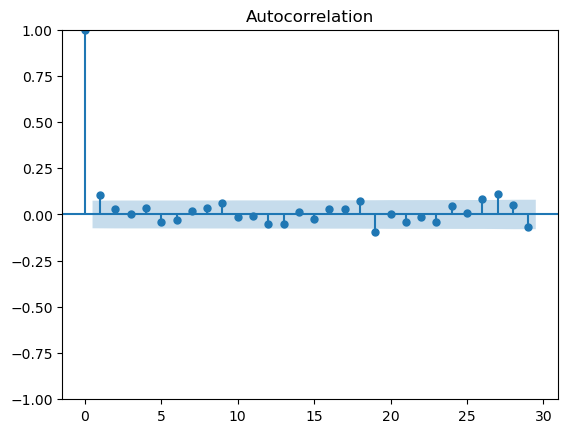

In [9]:
# ACF to examine the MA part -> MA(1) seems likely
plot_acf(df2_diff)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

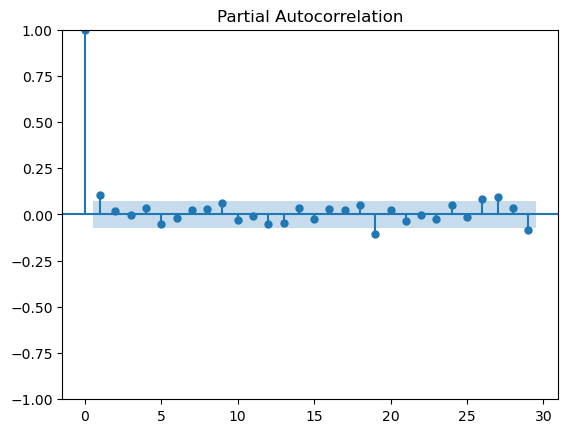

In [11]:
# PACF to examine the AR part -> AR(1) seems likely
plot_pacf(df2_diff, method = "ywm")
plt.show

### Try ARMA(1,1)

In [14]:
# Split data into training and testing datasets
train_end = dt.datetime(2023,9,1)
test_end = dt.datetime(2023,12,31)

train_data = df2_diff[:train_end]
test_data = df2_diff[train_end + dt.timedelta(days = 1):test_end]

In [19]:
# Model define
model_1 = ARIMA(train_data, order = (1,0,1))

C:\Users\jirka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jirka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\jirka\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [21]:
# fit the model
model_1_fit = model_1.fit()

In [22]:
# summary table -> only sigma2 significant, Does not make sense to use MA nor AR
print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    AQN   No. Observations:                  607
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 185.919
Date:                Tue, 02 Jan 2024   AIC                           -363.838
Time:                        09:23:00   BIC                           -346.204
Sample:                             0   HQIC                          -356.977
                                - 607                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0108      0.010     -1.124      0.261      -0.030       0.008
ar.L1          0.1959      0.482      0.406      0.684      -0.749       1.141
ma.L1         -0.1035      0.472     -0.219      0.8

## 2. Shell

Text(0.5, 1.0, 'Shell Price')

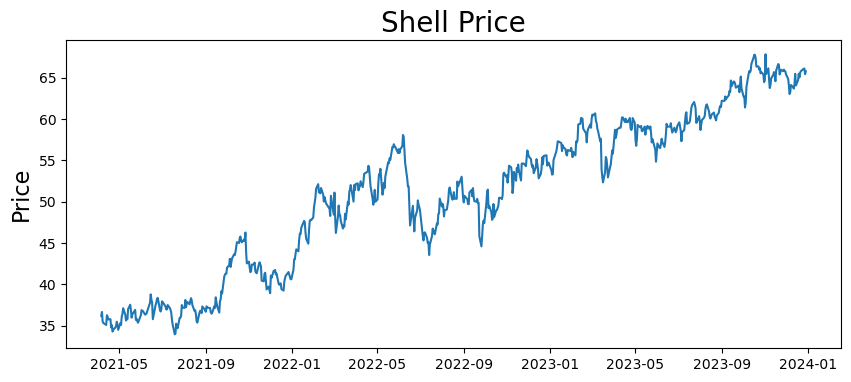

In [23]:
# Load the dataset
df3 = df_unsustain["SHEL"]

# Plot the price
plt.figure(figsize = (10, 4))
plt.plot(df3)
plt.ylabel("Price", fontsize = 16)
plt.title("Shell Price", fontsize = 20)

Text(0.5, 1.0, 'Shell Returns')

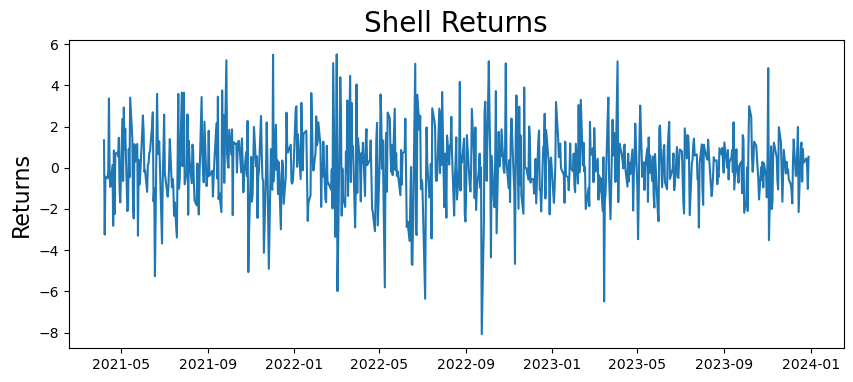

In [25]:
# calculate daily returns
returns_shell = 100 * df3.pct_change().dropna()

# Plot the returns
plt.figure(figsize = (10, 4))
plt.plot(returns_shell)
plt.ylabel("Returns", fontsize = 16)
plt.title("Shell Returns", fontsize = 20)

<function matplotlib.pyplot.show(close=None, block=None)>

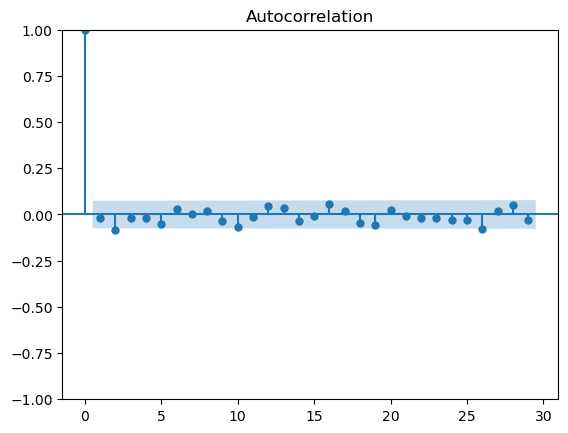

In [26]:
# ACF
plot_acf(returns_shell)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

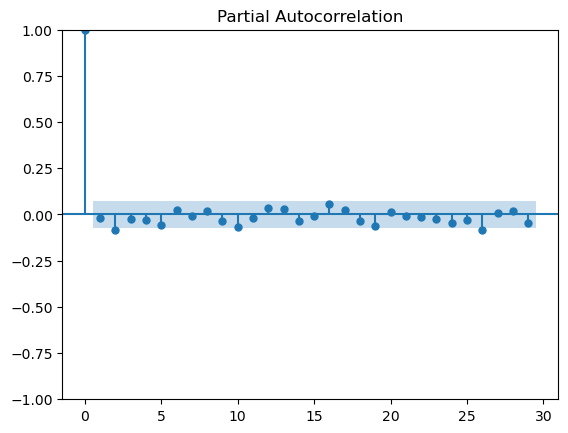

In [29]:
# PACF -> not a good candidate for ARIMA
plot_pacf(returns_shell, method = "ywm")
plt.show

### Try GARCH

<function matplotlib.pyplot.show(close=None, block=None)>

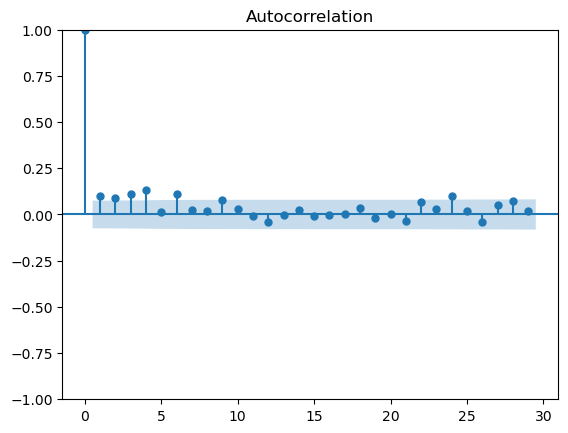

In [30]:
# ACF
plot_acf(returns_shell**2)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

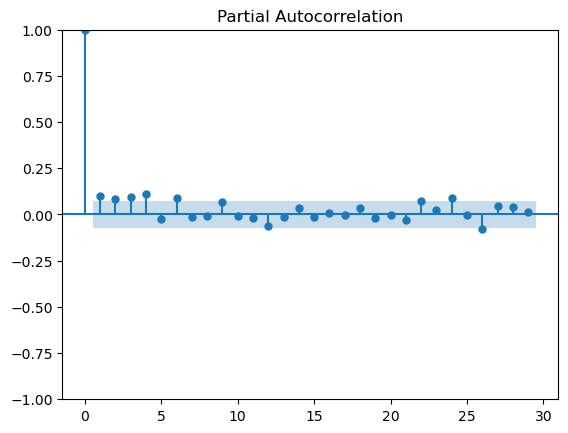

In [31]:
# PACF
plot_pacf(returns_shell**2, method = "ywm")
plt.show

### GARCH(3,3)

In [40]:
# Training and testing sets
# Split data into training and testing datasets
train_end_shell = dt.datetime(2023,9,1)
test_end_shell = dt.datetime(2023,12,31)

train_data_shell = returns_shell[:train_end_shell]
test_data_shell = returns_shell[train_end_shell + dt.timedelta(days = 1):test_end_shell]

In [41]:
# Define model
model_garch_shell = arch_model(train_data_shell, p=3, q=3)

In [42]:
# Fit the model
fit_garch_shell = model_garch_shell.fit()

Iteration:      1,   Func. Count:     10,   Neg. LLF: 2342.768838684481
Iteration:      2,   Func. Count:     21,   Neg. LLF: 1913.0427659407653
Iteration:      3,   Func. Count:     32,   Neg. LLF: 106446783.65173104
Iteration:      4,   Func. Count:     42,   Neg. LLF: 1255.2262161141011
Iteration:      5,   Func. Count:     52,   Neg. LLF: 1229.035871743692
Iteration:      6,   Func. Count:     62,   Neg. LLF: 1244.8814791984505
Iteration:      7,   Func. Count:     72,   Neg. LLF: 1227.2957643210393
Iteration:      8,   Func. Count:     82,   Neg. LLF: 1227.590582849991
Iteration:      9,   Func. Count:     92,   Neg. LLF: 1227.134430442829
Iteration:     10,   Func. Count:    102,   Neg. LLF: 1226.8613852407377
Iteration:     11,   Func. Count:    111,   Neg. LLF: 1226.8199616041625
Iteration:     12,   Func. Count:    120,   Neg. LLF: 1226.8176902856526
Iteration:     13,   Func. Count:    129,   Neg. LLF: 1226.817407219242
Iteration:     14,   Func. Count:    138,   Neg. LLF: 12

In [43]:
print(fit_garch_shell.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   SHEL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1226.82
Distribution:                  Normal   AIC:                           2469.63
Method:            Maximum Likelihood   BIC:                           2504.90
                                        No. Observations:                  607
Date:                Tue, Jan 02 2024   Df Residuals:                      606
Time:                        10:12:14   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1117  7.114e-02      1.570      0.116 [-2.77

### Try GARCH(0,3)

In [44]:
# Fit the model
model_garch_shell_2 = arch_model(train_data_shell, p=1, q=3)

garch_shell_2_fit = model_garch_shell_2.fit()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 603307792.0692785
Iteration:      2,   Func. Count:     18,   Neg. LLF: 4892.494632434927
Iteration:      3,   Func. Count:     28,   Neg. LLF: 1381.4253844332504
Iteration:      4,   Func. Count:     36,   Neg. LLF: 1226.6058162985
Iteration:      5,   Func. Count:     43,   Neg. LLF: 1227.786252949559
Iteration:      6,   Func. Count:     54,   Neg. LLF: 1226.8331274904351
Iteration:      7,   Func. Count:     62,   Neg. LLF: 1225.7672095643384
Iteration:      8,   Func. Count:     69,   Neg. LLF: 1225.7587205587354
Iteration:      9,   Func. Count:     76,   Neg. LLF: 1225.7528602656823
Iteration:     10,   Func. Count:     83,   Neg. LLF: 1225.752487504052
Iteration:     11,   Func. Count:     90,   Neg. LLF: 1225.752474202208
Iteration:     12,   Func. Count:     96,   Neg. LLF: 1225.7524742017094
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1225.752474202208
            Iterations: 

In [45]:
print(garch_shell_2_fit.summary()) # seems like a better fit

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   SHEL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1225.75
Distribution:                  Normal   AIC:                           2463.50
Method:            Maximum Likelihood   BIC:                           2489.96
                                        No. Observations:                  607
Date:                Tue, Jan 02 2024   Df Residuals:                      606
Time:                        10:12:58   Df Model:                            1
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu             0.1061  8.958e-02      1.184      0.236 [-6.95

### Predictions

In [54]:
#interval = test_end_shell - train_end_shell
#print(interval)

In [51]:
#prediction_shell = garch_shell_2_fit.forecast(horizon = 120)